# 546 (Optimization for Learning and Control) hw3

You are welcome (and encouraged) to work with others, but each individual must submit their own writeup.

You are welcome to use your preferred computational toolkit -- upload the **commented** sourcecode alongside your writeup (e.g. the .ipynb file).

You are welcome to consult research articles and other materials -- upload a .pdf of the article alongside your writeup and indicate which references were used where in the writeup.

In [ ]:
import numpy as np
import pylab as plt
from scipy import linalg as la
import scipy.stats as stats
import matplotlib.pylab as plt
import seaborn as sns
%matplotlib inline
figsize = (8,8)

# Markov decision process (MDP) (14 pts)

Let $(X,U,P,c)$ be an MDP:

* $X$ is a finite set of $N$ *states*;
* $U$ is a finite set of $M$ *actions*;
* $P:X\times U\rightarrow \Delta(X)$ specifies transition probabilities;
* $C:X\times U\rightarrow \mathbb{R}$ specifies transition cost.

Recall that $\Delta(S) = \{p : S \rightarrow [0,1] : \sum_{s\in S} p(s) = 1\}$ is the set of probability distributions over the finite set $S$.

a. *Implement an algorithm that generates a random MDP given finite sets $X$ and $U$ (i.e. let $N = |X|$, $M = |U|$ be parameters that are easy to vary, and generate $P$ and $c$ randomly).*

In [ ]:
# (1) initialize dimension
N = 5
M = 2

# (2) generate states and inputs
X = list(range(N))
U = list(range(M))

# (3) generate transition probabilities
P = np.abs(np.random.randn(N,M,N))
P = P / P.sum(axis=2)[...,np.newaxis]
assert np.all(P.min(axis=2) > 0),'no probability is zero'
assert np.all(P.max(axis=2) < 1),'no probability is one'
assert np.allclose(P.sum(axis=2), 1.),'probabilities sum to 1' 

# (4) generate costs
C = np.abs(np.random.randn(N,M,N))

# ---------------------------------------- Note: ---------------------------------------- 
# np.allclose:   function returns True if two arguements are element-wise equal within a tolerance.
# np.newaxis:    increase the dimension of the existing array by one more dimension, when used once. 
# assert:        assumptions that a programmer knows always wants to be true and hence puts them in
#                code so that failure of them doesn’t allow the code to execute further.

b. *Implement an algorithm that simulates an MDP (i.e. write a function that inputs transition probabilities $P$, cost $c$, initial state distribution $p_0$, policy $\pi:X\rightarrow\Delta(U)$, and time horizon $t$ and returns the state distribution $p_t$).*

In [ ]:
# (5) initial state distribution
p0 = np.abs(np.random.randn(N))    # p0.shape = (N,)
p0 = p0 / np.sum(p0)
assert np.allclose(np.sum(p0),1.)

# (6) policy
pi = np.abs(np.random.randn(N,M))   # pi.shape = (N,M)
pi = pi / np.sum(pi,axis=1)[:,np.newaxis]
assert np.allclose(np.sum(pi,axis=1),1.)

# (7) iterative MDP simulation
def MDP(X,U,P,C,p0,pi,T=1):
    p_all = [p0]               # state distribution over time
    for t in range(T):
        p_prev  = p_all[-1].copy()  # previous state distribution
        p_now = np.nan*p_prev       # current state distribution
        for x in X:                 
            p_now[x] = np.sum([[p_prev[xi] * pi[xi,mu] * P[xi,mu,x] for mu in U] for xi in X])
        assert np.allclose(np.sum(p_now),1.),"simulation must preserve probabilities"
        p_all.append(p_now)
    return p_all   # p_all will be a list of (T+1) shape (N,) matrices


# ---------------------------------------- Note: ---------------------------------------- 
# T:          the time horizon T is default as 1 in MDP if not particularly specified
# p_now[x]:   the expected probability that the next state will be x (no matter where it came from and
#             what the input mu previously was leading up to it)

c. *Test your algorithm from (b.) (i.e. design one or more tests, explain why these tests are exhaustive, and provide summary statistics and/or visualizations that convince a skeptical reader that your algorithm is correct).*

In [ ]:
for exp in range(3):
  T = np.random.randint(1,100)
  p0 = np.abs(np.random.randn(N))    # p0.shape = (N,)
  p0 = p0 / np.sum(p0)
  assert np.allclose(np.sum(p0),1.)

  # (8) Result from MDP simulation
  p_all = MDP(X,U,P,C,p0,pi,T)  
  Result_MDP = p_all[-1]   # final state distribution

  # (9) Result from matrix multiplication
  G = np.sum(pi[...,np.newaxis]*P,axis=1) 
  assert np.allclose(np.sum(G,axis=1),1.)
  Result_MMul = p0  
  for i in range(T):
    Result_MMul = np.dot(Result_MMul,G) # this is a row vector, so we do left multiplication on G

  # (10) Sanity Check: Result (8) and (9) should be identical
  assert np.allclose(Result_MDP, Result_MMul)

  print("\n------------ Experiment "+str(exp+1)+" ------------")
  print("initial state distribution:  \n\t"+str(p0))
  print("\nafter "+str(T)+" iterations...")
  print("\nfinal state distribution (with MDP): \n\t"+str(Result_MDP))
  print("\nfinal state distribution (with matrix multiplication): \n\t"+str(Result_MMul))

# ---------------------------------------- Note: ---------------------------------------- 
# pi:         a N-by-M policy matrix
# P:          a N-by-M-by-N state transition probability matrix
# G:          a N-by-N expected state transition probability matrix over policy 
#             it basically calculates pi[xi,mu] * P[xi,mu,x] for mu in U


------------ Experiment 1 ------------
initial state distribution:  
	[0.12059715 0.15400213 0.32097977 0.14233509 0.26208586]

after 14 iterations...

final state distribution (with MDP): 
	[0.20398322 0.19164816 0.20060466 0.21931978 0.18444417]

final state distribution (with matrix multiplication): 
	[0.20398322 0.19164816 0.20060466 0.21931978 0.18444417]

------------ Experiment 2 ------------
initial state distribution:  
	[0.15578714 0.08814962 0.41609975 0.23868835 0.10127513]

after 3 iterations...

final state distribution (with MDP): 
	[0.2034166  0.19302892 0.19919426 0.21986652 0.1844937 ]

final state distribution (with matrix multiplication): 
	[0.2034166  0.19302892 0.19919426 0.21986652 0.1844937 ]

------------ Experiment 3 ------------
initial state distribution:  
	[0.09650384 0.03198699 0.17891456 0.5272231  0.16537151]

after 84 iterations...

final state distribution (with MDP): 
	[0.20398322 0.19164816 0.20060466 0.21931978 0.18444417]

final state distributio

Let us now consider the problem of minimizing the infinite-horizon discounted cost
$$c = \sum_{t=0}^\infty \gamma^t C(x_t,u_t),$$
where $\gamma\in(0,1)$ is a ***discount factor***.

Any policy $\pi : X\rightarrow\Delta(U)$ has an associated ***value*** $v^\pi : X\rightarrow\mathbb{R}$ defined by
$$\forall x\in X : v^\pi(x) = E[c \mid x = x_0]$$
that satisfies the *Bellman equation*
$$\forall x\in X : v^\pi(x) = \sum_{u\in U}\pi(u|x)\sum_{x^+\in X} P(x^+|x,u)\left[C(x,u) + \gamma \cdot v^\pi(x^+)\right].$$

d. *Noting that $v^\pi$ appears linearly in this Bellman equation, implement a ***policy evaluation*** algorithm that computes $v^\pi$ using linear algebra (i.e. determing $L$ and $b$ such that $L v^\pi = b$ and use this equation to solve for $v^\pi$).*

<font color='red'>
Let's start from the Bellman equation:
$$\forall x\in X : v^\pi(x) = \sum_{u\in U}\pi(u|x)\sum_{x^+\in X} P(x^+|x,u)\left[C(x,u) + \gamma \cdot v^\pi(x^+)\right].$$
$$v^\pi(x) = \sum_{u\in U}\sum_{x^+\in X}\pi(u|x) P(x^+|x,u)C(x,u) + \gamma \sum_{u\in U}\sum_{x^+\in X}\pi(u|x) P(x^+|x,u)\cdot v^\pi(x^+).$$
$$v^\pi(x)-\gamma \sum_{u\in U}\sum_{x^+\in X}\pi(u|x) P(x^+|x,u)\cdot v^\pi(x^+) = \sum_{u\in U}\sum_{x^+\in X}\pi(u|x) P(x^+|x,u)C(x,u).$$</br>
Define $\delta:X\times X\rightarrow\{0,1\}$ is the Kronecker delta, i.e. $\delta(x,x^+) = 1 \iff x = x^+$.</br></br>
$$\sum_{x^+\in X}\delta(x,x^+)v^\pi(x^+)-\gamma \sum_{u\in U}\sum_{x^+\in X}\pi(u|x) P(x^+|x,u)\cdot v^\pi(x^+) = \sum_{u\in U}\sum_{x^+\in X}\pi(u|x) P(x^+|x,u)C(x,u).$$
$$\sum_{x^+\in X}\left(\delta(x,x^+)-\gamma \sum_{u\in U}\pi(u|x) P(x^+|x,u)\right) v^\pi(x^+) = \left(\sum_{u\in U}\sum_{x^+\in X}\pi(u|x) P(x^+|x,u)C(x,u)\right)$$</br>
Since $v^\pi$ appears linearly in the Bellman equation, we can solve for $v^\pi$ given $\pi$ using linear algebra:
$$L \cdot v^\pi = b$$
, where
$$L(x,x^+) = \delta(x,x^+) - \sum_{u\in U} \gamma\cdot \pi(u|x)\cdot P(x^+|x,u),$$
$$b(x) = \sum_{x^+\in X}\sum_{u\in U} \pi(u|x)\cdot P(x^+|x,u)\cdot C(x,u),$$</br>
Thus, the "policy evaluation" function solves for $v^\pi$ by:
$$ v^\pi = L^{-1}\cdot b$$
</font>

In [ ]:
# (11) choose a gamma value
g = np.random.rand()
print("The gamma chosen is: "+str(g))

# (12) policy evaluation
def policy_evaluation(X,U,P,C,g,pi):
    b = np.asarray([ np.sum([[pi[xi,mu] * P[xi,mu,x] * C[xi,mu,x] 
                          for x in X] for mu in U]) for xi in X])
    I = np.identity(len(X))
    L = I - np.asarray([ np.asarray([ np.sum([g * pi[xi,mu] * P[xi,mu,x] 
                                              for mu in U]) for x in X]) for xi in X])
    v = np.dot(b,la.inv(L).T) # since b is a row vector, we do left multiply
    return v

The gamma chosen is: 0.6207622268252085


e. *Test your policy evaluation algorithm from (d.) (i.e. design one or more tests, explain why these tests are exhaustive, and provide summary statistics and/or visualizations that convince a skeptical reader that your algorithm is correct).*

<font color='red'>
The resultant policy values $v^\pi\in\mathbb{R}^{|X|=N}$ is supposed to satisfy the Bellman equation (since $P(x^+|x,u) > 0$ for all $x,u,x^+$), so we validate the accuracy of $v^\pi$ by feeding it back to the Bellman equation and ensure that the equation holds.
</font>

In [ ]:
v = policy_evaluation(X,U,P,C,g,pi)
assert np.allclose(v, [np.sum([[pi[xi,mu] * P[xi,mu,x] * (C[xi,mu,x] + g*v[x]) 
                            for x in X] for mu in U]) for xi in X])

print("The values corresponding to each state is: "+str(v))

The values corresponding to each state is: [1.89847317 2.09931187 2.14463601 2.75563311 2.06501285]


f. *Using your policy evaluation algorithm from (d.), implement ***value iteration*** and ***policy iteration*** algorithms.*

<font color='red'>
Here, we implemented a total of four functions.</br>
1. First, the "policy improvement" function solves for
$$u^*(x)= \text{argmin}_{ u\in U}\left(\sum_{x^+\in X} P(x^+|x,u)\left[C(x,u) + \gamma \cdot v^\pi(x^+)\right]\right)$$
And then we update policy by $$\pi(u|x)=\delta(u,u^*(x))$$
, where $\delta:U\times U\rightarrow\{0,1\}$ is the Kronecker delta, i.e. $\delta(u,\hat u) = 1 \iff u = \hat u$.</br></br></br>
2. Next, the "policy iteration" is an iterative process that uses:</br>
(1) "policy evaluation" to solve for an updated value $v^\pi(x)$ based on current policy $\pi(x)$</br>
(2) "policy improvement" to solve for an updated policy $\pi(x)$ based on the recently updated value $v^\pi(x)$ </br>
(3) repeat step (1)(2) until $v^\pi(x)$ converges.</br></br></br>
3. Afterward, another function called "value update" is designed to calculate value $v^\pi(x)$ using Bellman equation.</br></br>
$$v^\pi(x) = \sum_{u\in U}\pi(u|x)\sum_{x^+\in X} P(x^+|x,u)\left[C(x,u) + \gamma \cdot v^\pi(x^+)\right]$$</br></br></br>
4. Finally, we can do "value iteration" by:</br>
(1) "value update" to calculate the value $v^\pi(x)$ based on current policy $\pi(x)$</br>
(2) "policy improvement" to solve for an updated policy $\pi(x)$ based on the recently updated value $v^\pi(x)$ </br>
(3) repeat step (1)(2) until $v^\pi(x)$ converges.</br></br></br>
</font>

In [ ]:
# (13) policy iteration
def policy_improvement(X,U,P,C,g,V):
    pi = np.zeros((N,M))
    for xi in X:
        u = np.argmin([np.sum([P[xi,mu,x]*(C[xi,mu,x] + g*V[x]) for x in X]) for mu in U])
        pi[xi,u] = 1.
    return pi

def policy_iteration(X,U,P,C,g,pi0):
    pi_all = [pi0]
    V_all  = []
    while len(V_all) < 2 or not(np.allclose(V_all[-1],V_all[-2])):
        pi_prev = pi_all[-1]
        V_now  = policy_evaluation(X,U,P,C,g,pi_prev)
        pi_now = policy_improvement(X,U,P,C,g,V_now)
        pi_all.append(pi_now)
        V_all.append(V_now)
    return pi_all,V_all

# (14) value iteration
def value_update(X,U,P,C,g,pi,V):
    return np.asarray([np.sum([[pi[xi,mu] * P[xi,mu,x] * (C[xi,mu,x] + g * V[x]) 
                                for x in X] for mu in U]) for xi in X])

def value_iteration(X,U,P,C,g,pi0,maxiter=100):
    pi_all = [pi0]
    V_all  = [np.zeros(N)]
    while len(V_all) < 2 or (not(np.allclose(V_all[-1],V_all[-2])) and len(V_all) < maxiter):
        pi_prev = pi_all[-1]
        V_prev  = V_all[-1]
        V_now = value_update(X,U,P,C,g,pi_prev,V_prev)
        pi_now = policy_improvement(X,U,P,C,g,V_now)
        pi_all.append(pi_now)
        V_all.append(V_now)
    return pi_all,V_all

g. *Test your value iteration and policy iteration algorithms from (f.) (i.e. design one or more tests, explain why these tests are exhaustive, and provide summary statistics and/or visualizations that convince a skeptical reader that your algorithm is correct).*


------------------ Policy Iteration (PI) ------------------
Total number of iterations: 3

State		Optimal value		Optimal policy
-------		--------------		--------------
X = 0		 1.342978		[1. 0.]
X = 1		 1.509363		[1. 0.]
X = 2		 1.618059		[1. 0.]
X = 3		 1.814670		[1. 0.]
X = 4		 1.696987		[0. 1.]

------------------ Value Iteration (VI) ------------------
Total number of iterations: 24

State		Optimal value		Optimal policy
-------		--------------		--------------
X = 0		 1.342957		[1. 0.]
X = 1		 1.509341		[1. 0.]
X = 2		 1.618038		[1. 0.]
X = 3		 1.814649		[1. 0.]
X = 4		 1.696966		[0. 1.]

policy discrepancy between VI and PI = 0
value discrepancy between VI and PI = 2.1e-05




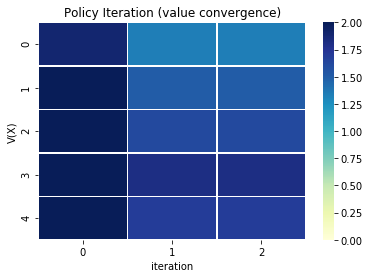

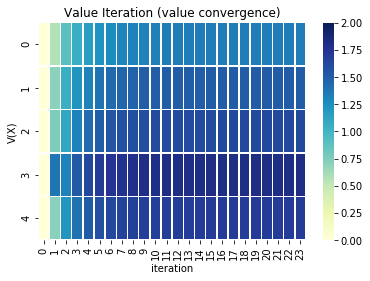

In [ ]:
# (15) Run Policy & Value Iteration
pi_PI,V_PI = policy_iteration(X,U,P,C,g,pi)
pi_VI,V_VI = value_iteration(X,U,P,C,g,pi,200)

# (16) Show Results
def show_MDP_result(X,N,pi_PI,V_PI,pi_VI,V_VI,text=True):
    if text:
        print ('\n------------------ Policy Iteration (PI) ------------------')
        print('Total number of iterations: '+str(len(V_PI)))
        print('\nState\t\tOptimal value\t\tOptimal policy')
        print('-------\t\t--------------\t\t--------------')
        for i in range(N):
          print('X = '+str(X[i])+'\t\t %02f' % np.asarray(V_PI[-1][i])+'\t\t'+str(np.asarray(pi_PI[-1][i,:])))

        print ('\n------------------ Value Iteration (VI) ------------------')
        print('Total number of iterations: '+str(len(V_VI)))
        print('\nState\t\tOptimal value\t\tOptimal policy')
        print('-------\t\t--------------\t\t--------------')
        for i in range(N):
          print('X = '+str(X[i])+'\t\t %02f' % np.asarray(V_VI[-1][i])+'\t\t'+str(np.asarray(pi_VI[-1][i,:])))

        print ('\npolicy discrepancy between VI and PI = %d'%np.max(np.abs(pi_VI[-1] - pi_PI[-1])))
        print ('value discrepancy between VI and PI = %0.1e\n\n'%np.max(np.abs(V_VI[-1] - V_PI[-1])))

    max_val = max(np.max(np.asarray(V_VI)),np.max(np.asarray(V_PI)))
    ax = sns.heatmap(np.asarray(V_PI).T, vmin=0.0, vmax=max_val, linewidth=0.5,  cmap="YlGnBu")
    ax.set_title('Policy Iteration (value convergence)')
    ax.set_xlabel('iteration')
    ax.set_ylabel('V(X)')
    plt.show()
    ax = sns.heatmap(np.asarray(V_VI).T, vmin=0.0, vmax=max_val, linewidth=0.5,  cmap="YlGnBu")
    ax.set_title('Value Iteration (value convergence)')
    ax.set_xlabel('iteration')
    ax.set_ylabel('V(X)')
    plt.show()

show_MDP_result(X,N,pi_PI,V_PI,pi_VI,V_VI, text=True)

<font color='red'> Since the policies and values agree to $> 7$ decimals, we regard them as yeilding the same result and confirm that both are correct.</font>

## linear quadratic regulation (6 pts)

Consider the linear-quadratic regulation (LQR) problem for the discrete-time linear time-invariant system
$$x^+ = A x + B u$$
with infinite-horizon cost
$$c(x,u) = \frac{1}{2}\sum_{t=0}^\infty x^T Q x + u^T R u \ dt$$
where  $Q = Q^T > 0$ and $R = R^T > 0$.  We know that the optimal policy is linear in state, 
$$u = - K x,$$
where $K = (R + B^T Y B)^{-1} (B^T Y A)$ and $Y$ satisfies the discrete algebraic Riccati equation
$$Y = A^T Y A - (A^T Y B)(R + B^T Y B)^{-1}(B^T Y A) + Q.$$

For this problem, we'll consider a one-dimensional system, so $x,u\in\mathbb{R}$, with the values $A, B, Q, R = 1$.

If the state distribution starts out Gaussian, 
$$x \sim \mathcal{N}(\xi, \Sigma),$$
and we apply zero input but add a state disturbance with zero mean and covariance $W$, then (so long as the disturbance is uncorrelated with the state) the state distribution after one step is Gaussian:
$$x^+ \sim \mathcal{N}(A\xi, A\Sigma A^T + W),$$
i.e. the covariance gets updated via
$$\Sigma^+ = A\Sigma A^T + W.$$
Since $A$ is stable, so long as $W$ is constant, this iteration will converge to a solution of the Lyapunov equation
$$S = A S A^T + W.$$
Also, since $A$ is stable, the steady-state mean is zero, thus we can determine the steady-state distribution in closed-form:
$$\lim_{t\rightarrow\infty} x(t) \sim \mathcal{N}(0, S).$$

In [ ]:
# (1) System Initialization
n,m = 1,1                           # dimension of state, input
A = np.asarray([[0.9]])             # system matrix A (did not use 1.0 because system becomes unstable)
B=Q=R = np.asarray([[1.0]])         # system matrix B, cost of state, input

# (2) Calculate Optimal Policy
Y = la.solve_discrete_are(A,B,Q,R)                   # calculate Y
K = np.dot( la.inv(R + np.dot( B.T, np.dot(Y, B))),  # calculate K 
            np.dot( B.T, np.dot( Y, A ) ) )
assert np.all(np.abs(la.eigvals(A - np.dot(B,K))) < 1),"u = - K x stabilizes x^+ = A x + B u"

# (3) Calculate Lyapunov
W=2.
S = la.solve_discrete_lyapunov(A,W)
assert np.allclose( S, np.dot(A, np.dot( S, A.T )) + W )

In this problem, you'll make use of the facts above to build a finite MDP that approximates the LQR, solve the MDP using your algorithms from the previous problem, then make use of the facts above again to validate the solution you've obtained.

a. *Construct a finite MDP by discretizing the state and action spaces of the linear system and computing transition probabilities and transition costs to obtain  $(X,U,P,C)$ where:*

* $X$ is a finite set of $N$ *states*;
* $U$ is a finite set of $M$ *actions*;
* $P:X\times U\rightarrow \Delta(X)$ specifies transition probabilities;
* $C:X\times U\times X\rightarrow \mathbb{R}$ specifies transition costs.

In [ ]:
# (4) Define MDP-LQR System
def Create_MDP_LQR(M,N,m,n):
    X = 15*2*(np.random.rand(N,n)-.5)    # discrete states
    U = 15*2*(np.random.rand(M,m)-.5)    # discrete actions
    X[0],U[0] = 0,0                      # include 0 as a state and an action

    P = np.nan*np.zeros((N,M,N))         # initialize transition probability
    C = np.nan*np.zeros((N,M,N))         # initizlize transition cost

    for x_idx,x in enumerate(X):              # loop over initial discrete state
      for u_idx,u in enumerate(U):            # loop over discrete actions
        x_next = np.dot(x,A.T)+np.dot(u,B.T)  # the deterministic next state
        P[x_idx,u_idx] = stats.multivariate_normal.pdf(X,mean=x_next,cov=W)
        C[x_idx,u_idx] = 0.5 *(np.dot(np.dot(x,Q),x) + np.dot(np.dot(u,R),u))

    P = P / P.sum(axis=2)[...,np.newaxis] # renormalize probabilities

    assert not np.any(np.isnan(P)),"all probabilities defined"
    assert not np.any(np.isnan(C)),"all costs defined"

    return X,U,P,C


N,M = 1000,5                         # number of discrete states, actions
X,U,P,C = Create_MDP_LQR(M,N,m,n)   

# ---------------------------------------- Note: ---------------------------------------- 
# multivariate_normal:     defines a Gaussian random variable with set mean and covariance
# multivariate_normal.pdf: evaluates the Gaussian PDF at certain input value
# P[x_idx,u_idx]:          determined by Gaussian PDF with mean Ax + Bu, covariance W
# C[x_idx,u_idx]:          generally need to loop over next discrete state, but in this case 
#                          cost doesn't depend on next state, so we can broadcast a scalar

b. *Compare the steady-state distribution of the MDP with the steady-state distribution of the linear system subject to zero-mean disturbance with covariance $W$.  Discuss how the comparison varies with respect to $|X|$.*

<font color='red'>
1. Extending from the MDP problem formulation... </br>
Let's apply zero input and construct the stochastic matrix $\Gamma : X \rightarrow \Delta(X)$ by
$$\forall x,x^+\in X : \Gamma(x)(x^+) = \sum_{u\in U} \pi(x)(u) P(x,u)(x^+)$$
and treating $p$ as a row vector, we can iterate $p^+ = p \Gamma$ until convergence.</br>
However, knowing that $\Gamma$ is a right-stochastic matrix (rows sum to 1) and assuming the MDP is irreducible, the unique steady-state distribution is the left eigenvector associated with the unity eigenvalue.</br></br>
2. Recall in the beginning of the LQR problem statement, it describes how the Lyapunov equation
$$S = A S A^T + W.$$
is used to represent the covariance of the steady-state distribution. 
$$\lim_{t\rightarrow\infty} x(t) \sim \mathcal{N}(0, S).$$
, where the steady-state mean is zero and the system matrix $A$ is stable. </br></br></br>
To verify that our MDP implementation is correct, we compare the steady-state distribution using the MDP based method (see 1.) and the Lyapunov based method (see 2.). We consider a successful test if the steady state distribution result matches. 
</font>

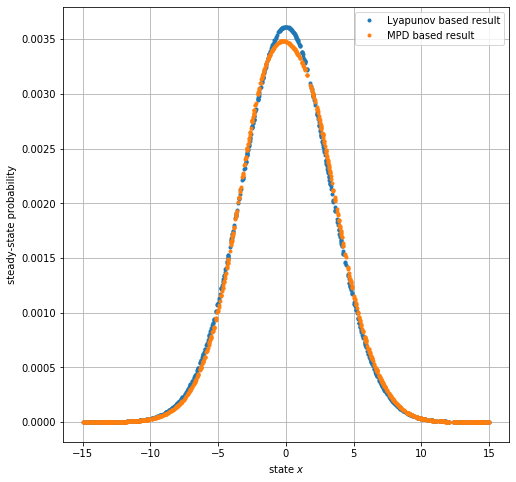

In [ ]:
# (5) MDP based method
pi = np.zeros((N,M)); pi[:,0] = 1.         # choose policy: no input (U[0] = 0)
G = np.sum(pi[...,np.newaxis]*P,axis=1)    # expected state transition probability
assert np.allclose(np.sum(G,axis=1),1.)

e,El,Er = la.eig(G,left=True)              # eigen value and eigen vectors
assert np.allclose(np.dot(El.T,G), (e*El).T), "rows of El.T are left eigenvectors of G"
MDP_result = El.T[np.argmax(np.abs(e))]    # the left eigen vector corresponding to largest eigen value
assert np.allclose(np.dot(MDP_result,G), MDP_result), "MDP_result is a stationary distribution"
MDP_result /= MDP_result.sum()             # normalize the probability distribution
assert np.allclose(MDP_result.imag,0.), "MDP_result is a real vector"
MDP_result = MDP_result.real               # get rid of imaginary parts

# (6) Lyapunov based method
LYP_result = stats.multivariate_normal.pdf(X,mean=np.zeros(n),cov=S)
LYP_result = LYP_result/LYP_result.sum()

# (7) Show Steady State Distribution
fig = plt.figure(figsize=figsize)
ax = plt.subplot(1,1,1); ax.grid('on')
ax.plot(X.flatten(),LYP_result,'.',label='Lyapunov based result')
ax.plot(X.flatten(),MDP_result,'.',label='MPD based result')
ax.set_ylabel('steady-state probability')
ax.set_xlabel('state $x$')
ax.legend()

# ---------------------------------------- Note: ---------------------------------------- 
# pi:         a N-by-M policy matrix
# P:          a N-by-M-by-N state transition probability matrix
# G:          a N-by-N expected state transition probability matrix over policy 
#             it basically calculates pi[xi,mu] * P[xi,mu,x] for mu in U
# la.eig:     returns the eigen values, and left right eigen vectors
# MDP_result: the steady-state distribution calculated from the MDP approximation. Note
#             that it is the left eigen vector corresponding to the largest eigen value
#             of the G matrix. And it needs to be properly normalized.

<font color='red'>
This comparison seems pretty good, and the steady-state distributions seem to overlap more closely as $|X|$ increases.
</font>

Now consider the problem of minimizing the infinite-horizon discounted cost
$$c = \sum_{t=0}^\infty \gamma^t C(x_t,u_t),$$
where $\gamma\in(0,1]$ is a *discount factor*.

The un-discounted case $\gamma = 1$ corresponds exactly to LQR; unfortunately, policy iteration won't converge when $\gamma = 1$!

c. *Compare the optimal value and control for the MDP obtained using value or policy iteration with the optimal value and control for the original LQR problem.  Discuss how the comparison varies with respect to $|X|$, $|U|$, and $\gamma$.*

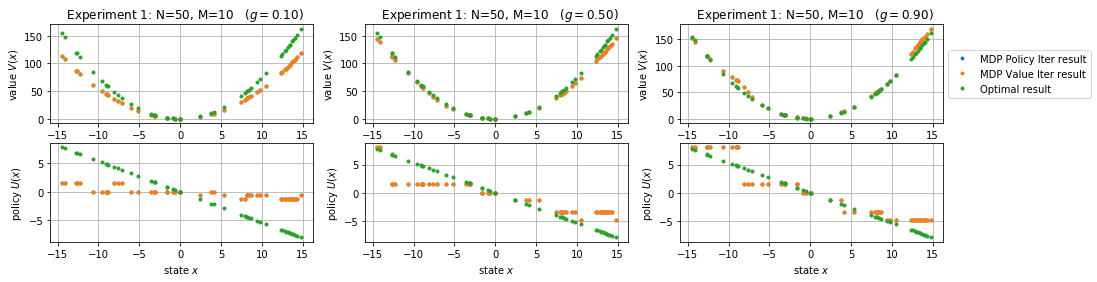

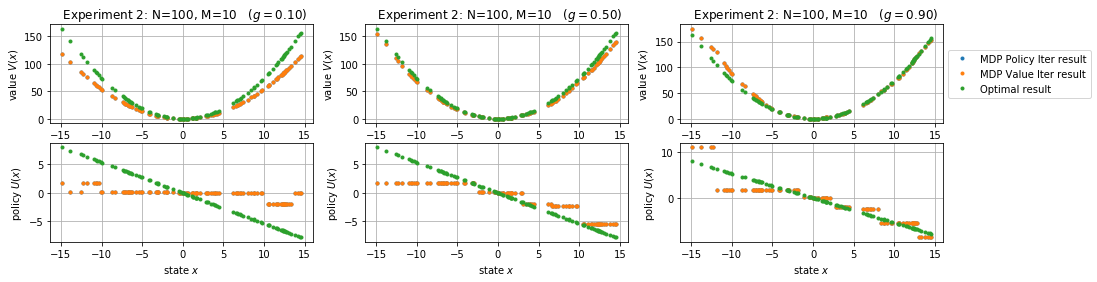

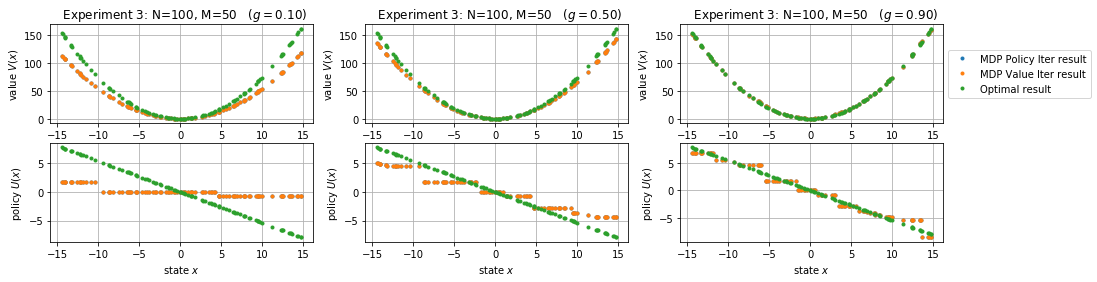

In [ ]:
figsize = (16,4)
g_list = [0.1,0.5,0.9]  # discount factor
N_list = [50,100,100]   # number of states
M_list = [10,10,50]     # number of actions

for exp in range(len(N_list)):
  
    plt.figure(figsize=figsize)         # initialize a figure
    M = M_list[exp]                     # number of states
    N = N_list[exp]                     # number of actions
    X,U,P,C = Create_MDP_LQR(M,N,m,n)   # create MDP-LQR

    # (8) Optimal LQR Calculation
    val_Opt = .5*np.diag(np.dot( np.dot(X,Y), X.T ))         # optimal value v(X)
    pi_Opt = -np.dot(K,X.T).flatten()                        # optimal policy pi(X)

    # (9) MDP Based LQR Calculation
    X_cnt = list(range(N)); U_cnt = list(range(M))           # integer form of X and U
    pi = np.abs(np.random.randn(N,M))                        # initial policy
    pi = pi / np.sum(pi,axis=1)[:,np.newaxis]
    assert np.allclose(np.sum(pi,axis=1),1.)    

    for g_idx,g in enumerate(g_list):

        pi_PI,V_PI = policy_iteration(X_cnt,U_cnt,P,C,g,pi)      # policy iteration
        pi_VI,V_VI = value_iteration(X_cnt,U_cnt,P,C,g,pi,200)   # value iteration

        # (10) draw result
        val_MDP_PI = V_PI[-1]-V_PI[-1][0]           # a list of values for each state
        val_MDP_VI = V_VI[-1]-V_VI[-1][0]           
        pi_MDP_PI = U[np.argmax(pi_PI[-1],axis=1)]  # a list of best actions for each state
        pi_MDP_VI = U[np.argmax(pi_VI[-1],axis=1)] 

        ax1 = plt.subplot(2,len(g_list),g_idx+1); ax1.grid('on')
        ax1.plot(X.flatten(),val_MDP_PI,'.',label='MDP Policy Iter result')
        ax1.plot(X.flatten(),val_MDP_VI,'.',label='MDP Value Iter result')
        ax1.plot(X.flatten(),val_Opt,'.',label='Optimal result')
        ax1.set_ylabel('value $V(x)$')
        if g_idx == 2:
            ax1.legend(loc="center left", bbox_to_anchor=(1,0.5))
        ax1.set_title('  Experiment '+str(exp+1)+': N='+str(N)+', M='+str(M)+'   ($g = %0.2f$)'  % g)

        ax2 = plt.subplot(2,len(g_list),g_idx+4); ax2.grid('on')
        ax2.plot(X.flatten(),pi_MDP_PI,'.',label='MDP Policy Iter result')
        ax2.plot(X.flatten(),pi_MDP_VI,'.',label='MDP Value Iter result')
        ax2.plot(X.flatten(),pi_Opt,'.',label='Optimal result ($g = %0.1f$)'  % g)
        ax2.set_ylabel('policy $U(x)$')
        ax2.set_xlabel('state $x$')

# ---------------------------------------- Note: ---------------------------------------- 
# pi_MDP:     a list of best actions for each state
# val_MDP:    a list of values for each state. Standardized the result by setting the
#             value at state X=0 to have to be zero.

<font color='red'>
Here is a summary of all my observations:</br>
1. The finite MDP provides a better approximation for larger $|X|$, $|U|$. </br>
2. The finite MDP provides a better approximation for larger $g$.</br>
3. I thought $\gamma$ would need to be very close to 1, e.g. $0.999$, but this doesn't appear to be the case -- even $\gamma = 0.5$ gives pretty similar results on this problem.</br>
4. As we also noticed from a previous subproblem, the MDP policy iteration and value iteration results are almost identical.
</font>

# paper / project presentation (4 pts)

You will give a combined paper / project presentation during the final two weeks of lecture, i.e. on Mar 3, 5, 10, or 12.

The paper presentation constitutes 30% of the course grade.  

The project constitutes 50% of the course grade, with the project presentation constituting 1/5 of that portion, so 10% of the course grade.

The presentations will be evaluated according to a simple rubric:  ***what did we learn, and how do we know we learned it?***  Your goal should be to (i) teach us something new (i.e. not covered in the course) and (ii) provide simple examples or exercises we can use to assess our understanding.  You should endeavor to adopt the notation and terminology from lecture (this may require translation from source material), and all new concepts and techniques must be defined and explained.

Each presenter will be allotted 20min of lecture time, including answering questions that arise during or after the presentations -- ***there will be a hard stop after 20min***.  To satisfy this constraint while maximizing your expected grade, you should prepare < 10min of material for the paper portion of the presentation and < 5min of material for the project presentation.  (*Hint:* you probably need to prepare less material than you expect -- to calibrate, I encourage you to practice your presentations with a colleague who actively asks questions.)

a. *Update your availability for presenting Mar 3, 5, 10, 12 in the shared document accessible via [Canvas Collaborations](https://canvas.uw.edu/courses/1352564/collaborations).*

b. Specify whether you are planning a solo or group project -- if group, specify your group members.